<a href="https://colab.research.google.com/github/cyrus2281/notes/blob/main/MachineLearning/PyTorch/LazyProgrammer/03_PyTorch_Applied_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

>[Content](#scrollTo=NJEQ6paQCREJ&uniqifier=2)

>[Recurrent Neural Networks](#scrollTo=xLCEXDUlCXcd&uniqifier=2)

>>[RNNs for Image Classification](#scrollTo=eGD76N1kCbvm&uniqifier=2)

>>[RNNs for Stock Return Prediction](#scrollTo=4_hWgrOkCknq&uniqifier=2)

>>>[Price Prediction](#scrollTo=7JQ-aWBwH6zM&uniqifier=2)

>>>[Returns](#scrollTo=tHOwz6LxH4RJ&uniqifier=2)

>>>[Binary Classification](#scrollTo=mLVRD2tmHxoJ&uniqifier=2)

>[Convolutional Neural Networks](#scrollTo=ygOcP49fTl89&uniqifier=2)

>>[CNN for Text Classification](#scrollTo=8IN6rxx4TxNY&uniqifier=2)

>[Recommender Systems](#scrollTo=ZXwiqfwHoNdR&uniqifier=2)

>[Stock Prediciton with Reinforcement Learning](#scrollTo=EdwFMJ1A_GU0&uniqifier=2)



# Recurrent Neural Networks

## RNNs for Image Classification

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True)
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# Build the model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc =nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = RNN(28, 128, 2, 10)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Train the model
n_epochs = 10

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  train_loss = np.mean(train_loss) # a little misleading

  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 28, 28)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.5841, Test Loss: 0.1778
Epoch 2/10, Train Loss: 0.1344, Test Loss: 0.0895
Epoch 3/10, Train Loss: 0.0873, Test Loss: 0.0842
Epoch 4/10, Train Loss: 0.0611, Test Loss: 0.0652
Epoch 5/10, Train Loss: 0.0539, Test Loss: 0.0577
Epoch 6/10, Train Loss: 0.0441, Test Loss: 0.0483
Epoch 7/10, Train Loss: 0.0356, Test Loss: 0.0553
Epoch 8/10, Train Loss: 0.0344, Test Loss: 0.0473
Epoch 9/10, Train Loss: 0.0310, Test Loss: 0.0385
Epoch 10/10, Train Loss: 0.0253, Test Loss: 0.0550


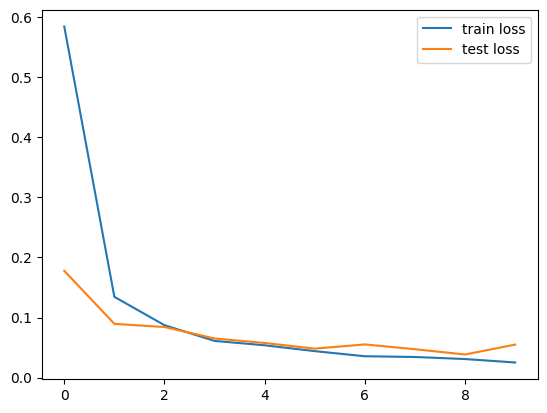

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9893, Test acc: 0.9834


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 977    0    1    0    0    0    1    1    0    0]
 [   1 1124    2    0    0    0    1    3    3    1]
 [   4    0 1019    0    2    0    2    5    0    0]
 [   0    0    3 1003    0    0    0    2    0    2]
 [   0    0    0    0  965    0    4    1    0   12]
 [   1    0    1   22    0  849    3    2   11    3]
 [  12    2    0    0    3    2  931    0    7    1]
 [   0    1    3    0    2    0    0 1019    0    3]
 [   5    0    1    5    1    1    1    4  955    1]
 [   1    0    0    1    9    0    0    3    3  992]]


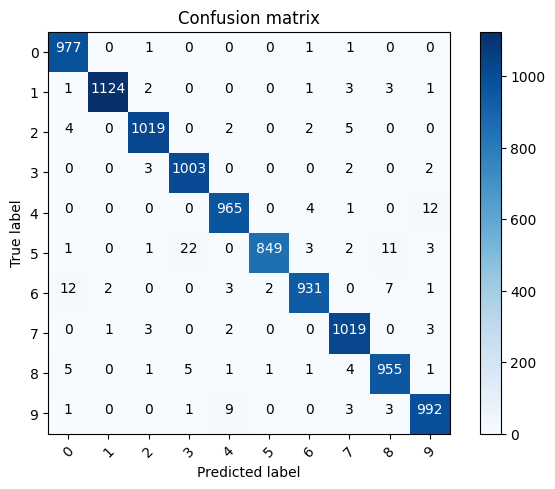

In [ ]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 28, 28)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

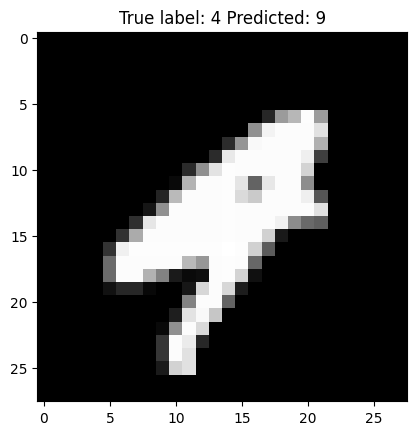

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));

## RNNs for Stock Return Prediction

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Price Prediction

In [ ]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [ ]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [ ]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [ ]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [ ]:
### try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    out, _ = self.rnn(X, (h0, c0))

    # we only want h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
model = RNN(1, 5, 1, 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 50 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(
  model,
  criterion,
  optimizer,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 50/200, Train Loss: 0.0062, Test Loss: 0.0274
Epoch 100/200, Train Loss: 0.0052, Test Loss: 0.0177
Epoch 150/200, Train Loss: 0.0051, Test Loss: 0.0154
Epoch 200/200, Train Loss: 0.0051, Test Loss: 0.0146


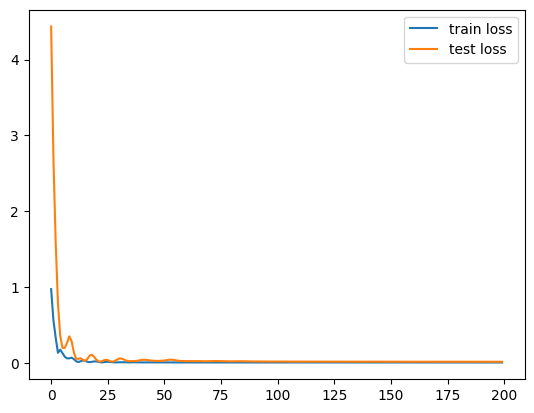

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

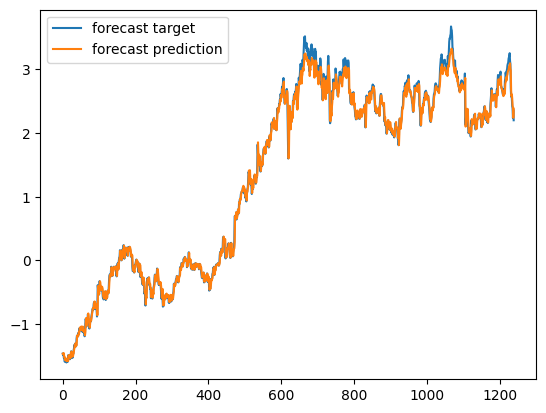

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

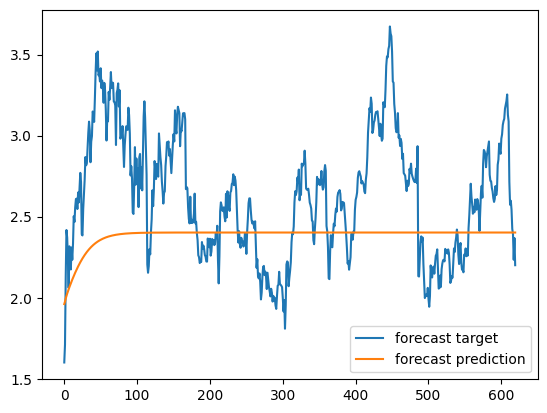

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Returns

In [ ]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


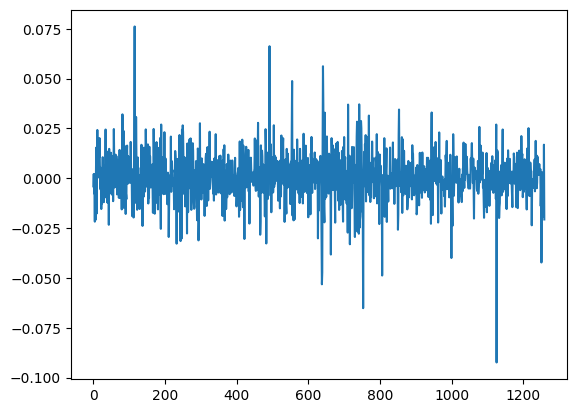

In [ ]:
plt.plot(df['Return']);

<Axes: >

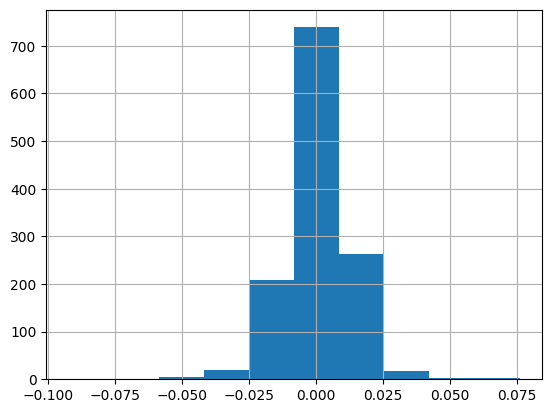

In [ ]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [ ]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [ ]:
### try autoregressive RNN model
model = RNN(1, 5, 1, 1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(
  model,
  criterion,
  optimizer,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 50/200, Train Loss: 1.0505, Test Loss: 1.0722
Epoch 100/200, Train Loss: 1.0282, Test Loss: 1.0925
Epoch 150/200, Train Loss: 0.9658, Test Loss: 1.1462
Epoch 200/200, Train Loss: 0.8998, Test Loss: 1.2774


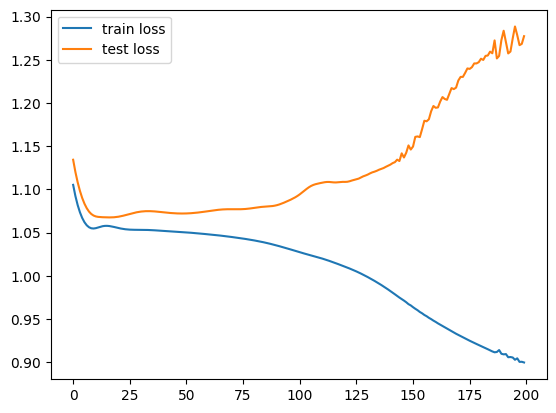

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# One-step forecast using true targets
validation_target = Y
validation_predictions = []

# index of first validation input
i = 0

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1, T, 1)
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

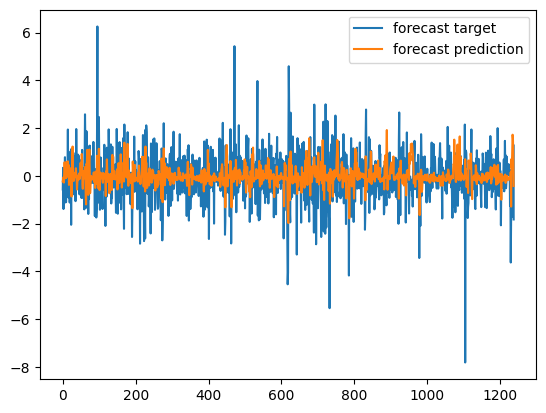

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1, T, 1)
  p = model(input_)
  # [0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

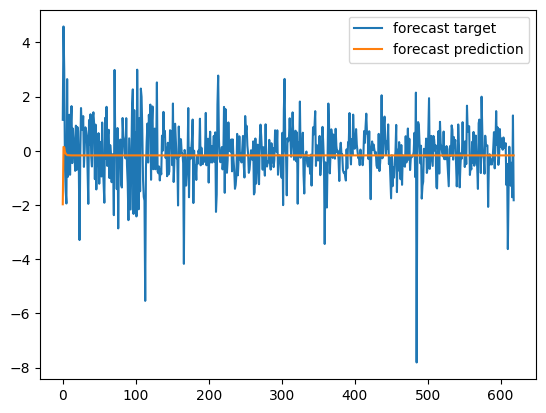

In [ ]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### Binary Classification

In [ ]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [ ]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [ ]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [ ]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [ ]:
# make the RNN
model = RNN(5, 50, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [ ]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [ ]:
train_losses, test_losses = full_gd(
  model,
  criterion,
  optimizer,
  X_train,
  y_train,
  X_test,
  y_test,
  epochs=300
)

Epoch 50/300, Train Loss: 0.6442, Test Loss: 0.7603
Epoch 100/300, Train Loss: 0.4464, Test Loss: 1.1384
Epoch 150/300, Train Loss: 0.2100, Test Loss: 1.8230
Epoch 200/300, Train Loss: 0.0393, Test Loss: 2.4696
Epoch 250/300, Train Loss: 0.0023, Test Loss: 3.4688
Epoch 300/300, Train Loss: 0.0008, Test Loss: 3.7013


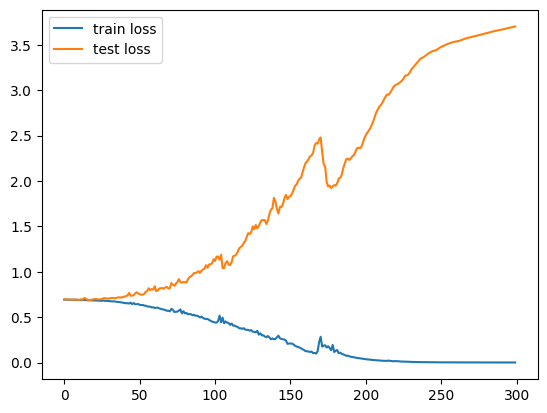

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Get accuracy
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 1.0000, Test acc: 0.5024


# Convolutional Neural Networks



## CNN for Text Classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

# drop unnecesary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

df.columns = ['labels', 'data']

df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [ ]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

In [ ]:
# 0 = padding
idx = 1
word2idx = {'<PAD>': 0}

In [ ]:
# you could always use gensim or spacy for tokenization,
# but let's keep it simple!
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split() # simple tokenization(lower-> lowercase the text; split-> split phrase using spaces)
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [ ]:
word2idx["you"], len(word2idx)

(27, 10578)

In [ ]:
# convert data into word indices
# note: could hae done this on the fly earlier
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [ ]:
# convert data into word indices
# note: could hae done this on the fly earlier
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

In [ ]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

In [ ]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X,y)
  n_batches = int(np.ceil(len(y) / batch_size))
  for i in range(n_batches):
    end = min((i+1) * batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # pad X_batch to be N x T
    max_len = np.max([len(x) for x in X_batch]) # all batches with the max size
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

      # convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()

    yield X_batch, y_batch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# What is the shape of embedding output?
# N x T x D
embed = nn.Embedding(len(word2idx),20)
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  out = embed(inputs)
  print("Input shape:", inputs.shape)
  print("Output shape", out.shape)
  break

Input shape: torch.Size([32, 60])
Output shape torch.Size([32, 60, 20])


In [ ]:
from numpy.core.numeric import outer
# Define the model
class CNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_outputs):
    super(CNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.K = n_outputs

    # if input is T words
    # then outputs is (T, D) matrix
    self.embed = nn.Embedding(self.V, self.D)

    # conv layers
    self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1)
    self.pool1 = nn.MaxPool1d(2)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
    self.pool2 = nn.MaxPool1d(2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=1)

    self.fc = nn.Linear(128, self.K)

  def forward(self, X):
    # embedding layers
    # turns word indexes into words vectors
    out = self.embed(X)

    # note: output of embedding is always
    # (N, T, D)
    # conv1d expects
    # (N, D, T)

    # conv layers
    out = out.permute(0, 2, 1)
    out = self.conv1(out)
    out = F.relu(out)
    out = self.pool1(out)
    out = self.conv2(out)
    out = F.relu(out)
    out = self.pool2(out)
    out = self.conv3(out)
    out = F.relu(out)

    # change it back
    out = out.permute(0, 2, 1)

    # max pool
    out, _ = torch.max(out, 1)

    # final dense layer
    out = self.fc(out)
    return out

In [ ]:
model = CNN(len(word2idx), 20, 1)
model.to(device)

CNN(
  (embed): Embedding(10578, 20)
  (conv1): Conv1d(20, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_gen():
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_gen():
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, 15)

Epoch 1/15, Train Loss: 0.3385,       Test Loss: 0.2312, Duration: 0:00:02.780406
Epoch 2/15, Train Loss: 0.1896,       Test Loss: 0.1494, Duration: 0:00:00.604052
Epoch 3/15, Train Loss: 0.1239,       Test Loss: 0.1716, Duration: 0:00:00.558386
Epoch 4/15, Train Loss: 0.0926,       Test Loss: 0.1354, Duration: 0:00:00.586933
Epoch 5/15, Train Loss: 0.0704,       Test Loss: 0.1206, Duration: 0:00:00.484423
Epoch 6/15, Train Loss: 0.0486,       Test Loss: 0.1019, Duration: 0:00:00.427152
Epoch 7/15, Train Loss: 0.0314,       Test Loss: 0.1491, Duration: 0:00:00.404591
Epoch 8/15, Train Loss: 0.0188,       Test Loss: 0.1271, Duration: 0:00:00.416506
Epoch 9/15, Train Loss: 0.0159,       Test Loss: 0.1295, Duration: 0:00:00.413302
Epoch 10/15, Train Loss: 0.0105,       Test Loss: 0.1561, Duration: 0:00:00.407300
Epoch 11/15, Train Loss: 0.0087,       Test Loss: 0.1453, Duration: 0:00:00.428087
Epoch 12/15, Train Loss: 0.0071,       Test Loss: 0.1426, Duration: 0:00:00.419409
Epoch 13/15, 

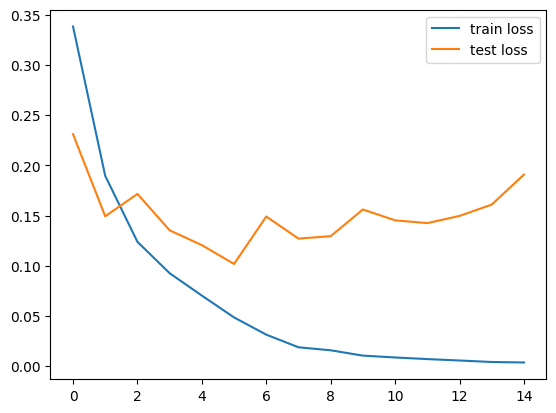

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9992, Test acc: 0.9690


# Recommender Systems

In [ ]:
import torch
import torch.nn as nn
import torch.nn. functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2024-01-03 04:55:54--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  54.6MB/s    in 3.8s    

2024-01-03 04:55:58 (50.0 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [ ]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [ ]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df[ 'new_user_id'].values
movie_ids=df ['new_movie_id'].values
ratings=df['rating'].values - 2.5

# Get number of users and number of movies
N = len (set (user_ids))
M = len (set (movie_ids))

# Set embedding dimension
D = 10

In [ ]:
# Make a neural network
class Model (nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N= n_users
    self.M= n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb= nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0,1) leads to poor results when normalized again
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))

  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u,m), 1) # output is (num-samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Model(N,M,D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings=shuffle(user_ids, movie_ids, ratings)

# convert to tensors
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings)

In [ ]:
# Make datasets
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain],
)
test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:],
)

In [ ]:
# Data loaders - Doesn't perform well

# batch_size=512
# train_loader=torch.utils.data.DataLoader(
#   dataset=train_dataset,
#   batch_size=batch_size,
#   shuffle=True
# )

# test_loader = torch.utils.data.DataLoader(
#   dataset=test_dataset,
#   batch_size=batch_size,
#   shuffle=False
# )

In [ ]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # Get the batch and convert to tensor
      users = torch.from_numpy(train_users[j*bs:(j+1)*bs]).long()
      movies = torch.from_numpy(train_movies[j*bs:(j+1)*bs]).long()
      targets = torch.from_numpy(train_ratings[j*bs:(j+1)*bs])

      # reshape targets
      targets = targets.view(-1,1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users,movies)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      users = torch.from_numpy(test_users[j*bs:(j+1)*bs]).long()
      movies = torch.from_numpy(test_movies[j*bs:(j+1)*bs]).long()
      targets = torch.from_numpy(test_ratings[j*bs:(j+1)*bs])

      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()

      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  return train_losses, test_losses

In [ ]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings [Ntrain:]

train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10
)

Epoch 1/10, Train Loss: 0.7261,       Test Loss: 0.6816, Duration: 0:01:18.506163
Epoch 2/10, Train Loss: 0.6511,       Test Loss: 0.6484, Duration: 0:01:18.769216
Epoch 3/10, Train Loss: 0.6164,       Test Loss: 0.6394, Duration: 0:01:17.965823
Epoch 4/10, Train Loss: 0.5967,       Test Loss: 0.6322, Duration: 0:01:18.087231
Epoch 5/10, Train Loss: 0.5837,       Test Loss: 0.6288, Duration: 0:01:18.079789
Epoch 6/10, Train Loss: 0.5745,       Test Loss: 0.6284, Duration: 0:01:18.875714
Epoch 7/10, Train Loss: 0.5677,       Test Loss: 0.6267, Duration: 0:01:19.568447
Epoch 8/10, Train Loss: 0.5627,       Test Loss: 0.6265, Duration: 0:01:17.964929
Epoch 9/10, Train Loss: 0.5587,       Test Loss: 0.6257, Duration: 0:01:18.114909
Epoch 10/10, Train Loss: 0.5553,       Test Loss: 0.6267, Duration: 0:01:17.945563


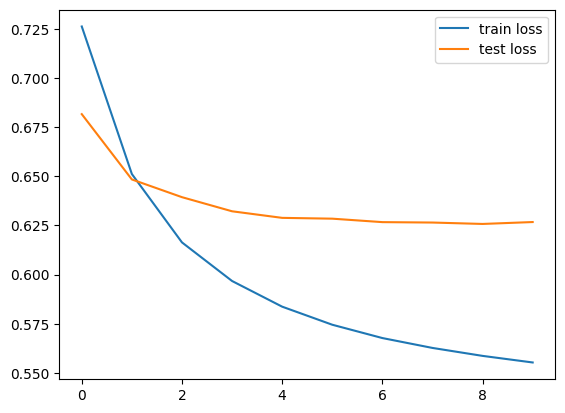

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# Stock Prediciton with Reinforcement Learning

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import itertools
import re
import os
import pickle
from sklearn.preprocessing import StandardScaler

In [4]:
# get the data
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/aapl_msi_sbux.csv

--2024-01-06 04:18:23--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/aapl_msi_sbux.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24098 (24K) [text/plain]
Saving to: ‘aapl_msi_sbux.csv’

aapl_msi_sbux.csv   100%[===================>]  23.53K  --.-KB/s    in 0.001s  

2024-01-06 04:18:23 (39.1 MB/s) - ‘aapl_msi_sbux.csv’ saved [24098/24098]



In [5]:
# Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
def get_data():
  # returns a T x 3 list of stock prices
  # each row is a different stock
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv('aapl_msi_sbux.csv')
  return df.values

In [6]:
# The experience replay memory
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf=np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf=np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf=np.zeros(size, dtype=np. uint8)
    self.rews_buf=np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np. uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch (self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(
        s=self.obs1_buf[idxs],
        s2=self.obs2_buf[idxs],
        a=self.acts_buf[idxs],
        r=self.rews_buf[idxs],
        d=self.done_buf[idxs])

In [7]:
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here
  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

In [8]:
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

In [10]:
class MLP (nn.Module):
  def __init__(self, n_inputs, n_action, n_hidden_layers=1, hidden_dim=32):
    super(MLP, self).__init__()

    M = n_inputs
    layers = []
    for _ in range(n_hidden_layers):
      layer = nn. Linear (M, hidden_dim)
      M = hidden_dim
      layers.append(layer)
      layers.append(nn.ReLU())

    # final layer
    layers.append(nn. Linear (M, n_action))
    self.layers = nn.Sequential(*layers)

  def forward(self, X):
    return self.layers(X)

  def save_weights (self, path):
    torch.save(self.state_dict(), path)

  def load_weights (self, path):
    self.load_state_dict(torch.load(path))

In [11]:
def predict(model, np_states):
  with torch.no_grad():
    inputs = torch.from_numpy(np_states.astype(np.float32))
    output = model(inputs)
    return output.numpy()

In [12]:
def train_one_step(model, criterion, optimizer, inputs, targets):
  # convert to tensors
  inputs = torch.from_numpy (inputs.astype(np.float32))
  targets = torch.from_numpy (targets.astype (np.float32))

  # zero the parameter gradients
  optimizer.zero_grad()

  # Forward pass
  outputs = model(inputs)
  loss = criterion(outputs, targets)

  # Backward and optimize
  loss.backward()
  optimizer.step()

In [14]:
class MultiStockEnv:
  """
  A 3-stock trading environment.
  State: vector of size 7 (n_stock * 2 + 1)
    - # shares of stock 1 owned
    - # shares of stock 2 owned
    - # shares of stock 3 owned
    - price of stock 1 (using daily close price)
    - price of stock 2
    - price of stock 3
    - cash owned (can be used to purchase more stocks)
  Action: categorical variable with 27 (3^3) possibilities
    - for each stock, you can:
    - 0 = sell
    - 1 = hold
    - 2 = buy
  """

  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0]
    # [0,0,1]
    # [0,0,2]
    # [0,1,0]
    # [0,1,1]
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    self.action_list = list(
        map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()

  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()

  def step(self, action):
    assert action in self.action_space

    # get current value before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info

  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs

  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vec = self.action_list[action]

    # determine which stocks to buy or sell
    sell_index = []  # stores index of stocks we want to sell
    buy_index = []  # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      #       and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1  # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False

In [15]:
class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = ReplayBuffer(state_size, action_size, size=500)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = MLP(state_size, action_size)

    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters())

  def update_replay_memory(self, state, action, reward, next_state, done):
    self.memory.store(state, action, reward, next_state, done)

  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = predict(self.model, state)
    return np.argmax(act_values[0])  # returns action

  def replay(self, batch_size=32):
    # first check if replay buffer contains enough data
    if self.memory.size < batch_size:
      return

    # sample a batch of data from the replay memory
    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    actions = minibatch['a']
    rewards = minibatch['r']
    next_states = minibatch['s2']
    done = minibatch['d']

    # Calculate the tentative target: Q(s',a)
    target = rewards + (1-done) * self.gamma * \
        np.amax(predict(self.model, next_states), axis=1)

    # With the Keras API, the target (usually) must have the same
    # shape as the predictions.
    # However, we only need to update the network for the actions
    # which were actually taken.
    # We can accomplish this by setting the target to be equal to
    # the prediction for all values.
    # Then, only change the targets for the actions taken.
    # Q(s,a)
    target_full = predict(self.model, states)
    target_full[np.arange(batch_size), actions] = target

    # Run one training step
    train_one_step(self.model, self.criterion, self.optimizer, states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  def load(self, name):
    self.model.load_weights(name)

  def save(self, name):
    self.model.save_weights(name)

In [16]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val']

In [18]:
# Train

# config
models_folder = 'rl_trader_models'
rewards_folder = 'rl_trader_rewards'
num_episodes = 200
batch_size = 32
initial_investment = 20000

maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# store the final value of the portfolio (end of episode)
portfolio_value = []

# play the game num_episodes times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, "train")
  dt = datetime.now() - t0
  print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
  portfolio_value.append(val)  # append episode end portfolio value

# save the weights when we are done
agent.save(f'{models_folder}/dqn.h5')

# save the scaler
with open(f'{models_folder}/scaler.pkl', 'wb') as f:
  pickle.dump(scaler, f)

# save portfolio value for each episode
np.save(f'{rewards_folder}/train.npy', portfolio_value)

episode: 1/200, episode end value: 35764.50, duration: 0:00:00.886169
episode: 2/200, episode end value: 27022.76, duration: 0:00:01.275945
episode: 3/200, episode end value: 33664.86, duration: 0:00:00.978873
episode: 4/200, episode end value: 33776.26, duration: 0:00:01.086203
episode: 5/200, episode end value: 33896.32, duration: 0:00:01.194495
episode: 6/200, episode end value: 34384.43, duration: 0:00:01.337597
episode: 7/200, episode end value: 33064.87, duration: 0:00:01.900634
episode: 8/200, episode end value: 33161.81, duration: 0:00:02.070691
episode: 9/200, episode end value: 34353.67, duration: 0:00:01.815555
episode: 10/200, episode end value: 33325.83, duration: 0:00:01.649480
episode: 11/200, episode end value: 33222.63, duration: 0:00:00.894354
episode: 12/200, episode end value: 36210.46, duration: 0:00:00.888316
episode: 13/200, episode end value: 30445.74, duration: 0:00:01.054365
episode: 14/200, episode end value: 33664.89, duration: 0:00:01.196143
episode: 15/200

In [19]:
# Test

# config
models_folder = 'rl_trader_models'
rewards_folder = 'rl_trader_rewards'
num_episodes = 100
batch_size = 32
initial_investment = 20000

maybe_make_dir(models_folder)
maybe_make_dir(rewards_folder)

data = get_data()
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2

train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

# store the final value of the portfolio (end of episode)
portfolio_value = []

# then load the previous scaler
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
  scaler = pickle.load(f)

# remake the env with test data
env = MultiStockEnv(test_data, initial_investment)

# make sure epsilon is not 1!
# no need to run multiple episodes if epsilon = 0, it's deterministic
agent.epsilon = 0.01

# load trained weights
agent.load(f'{models_folder}/dqn.h5')

# play the game num_episodes times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, "test")
  dt = datetime.now() - t0
  print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
  portfolio_value.append(val)  # append episode end portfolio value

# save portfolio value for each episode
np.save(f'{rewards_folder}/test.npy', portfolio_value)

episode: 1/100, episode end value: 27675.53, duration: 0:00:00.226478
episode: 2/100, episode end value: 26766.00, duration: 0:00:00.235228
episode: 3/100, episode end value: 27559.75, duration: 0:00:00.236046
episode: 4/100, episode end value: 27684.97, duration: 0:00:00.164276
episode: 5/100, episode end value: 27532.24, duration: 0:00:00.151916
episode: 6/100, episode end value: 27486.99, duration: 0:00:00.156832
episode: 7/100, episode end value: 28703.49, duration: 0:00:00.161213
episode: 8/100, episode end value: 27153.85, duration: 0:00:00.163272
episode: 9/100, episode end value: 27680.06, duration: 0:00:00.177420
episode: 10/100, episode end value: 27677.97, duration: 0:00:00.146649
episode: 11/100, episode end value: 26008.28, duration: 0:00:00.156494
episode: 12/100, episode end value: 27804.33, duration: 0:00:00.151844
episode: 13/100, episode end value: 27728.61, duration: 0:00:00.156905
episode: 14/100, episode end value: 28132.01, duration: 0:00:00.151055
episode: 15/100

Train: average reward: 34420.20, min: 19732.58, max: 53090.27
Test: average reward: 27613.67, min: 25869.01, max: 30314.92


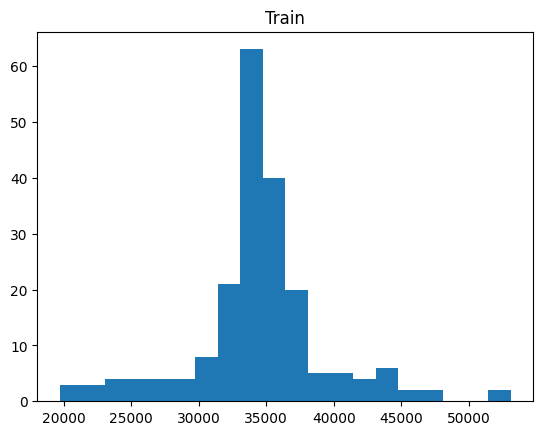

In [21]:
# PLOT REWARDS
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.load(f'rl_trader_rewards/train.npy')
test_rewards = np.load(f'rl_trader_rewards/test.npy')

print(f"Train: average reward: {train_rewards.mean():.2f}, min: {train_rewards.min():.2f}, max: {train_rewards.max():.2f}")
print(f"Test: average reward: {test_rewards.mean():.2f}, min: {test_rewards.min():.2f}, max: {test_rewards.max():.2f}")

plt.hist(train_rewards, bins=20)
plt.title("Train")
plt.show()

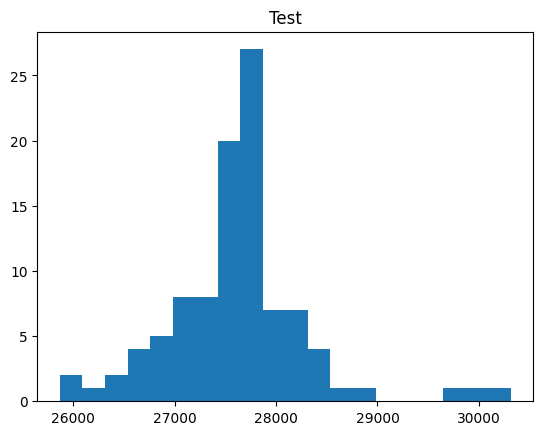

In [22]:
plt.hist(test_rewards, bins=20)
plt.title("Test")
plt.show()